# NNs for jet images

Notebook for training and evaluating neural network taggers using jet images.

This example is about separating jets (collimated sprays of hadronic particles) using an "imaging" technique based on a convolutional neural network. SignaL jets are from hadronic decays of W bosons, while background jets are produced from the hadronisation of light quarks, or gluons. The jets are measured in the detector calorimeter, where they leave their energy. The images are the trnasverse energies deposited by a jet in the calorimeter cells, with each image being centred on the jet axis, and the weight of each cell is the transverse energy deposited. Jets from background tend to have most of the transverse enrgy deposited in the centre, while those from BG, that are actually composed of two very nearby jets, present rather a two-prong structure, and the network should be able to distinguish the two cases.
Write a concolutional neural network to distinguish the teo classes, train it, and evaluate its performance.

### Import everything

In [100]:
from __future__ import division, print_function

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from datetime import datetime
import os, sys
home_dir = os.getcwd()+'/'
print ("The Home Directory is set to:", home_dir) # check the home directory

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib

The Home Directory is set to: C:\Users\safee\Desktop\Python\Mini-Project Folder/


# My Code

### Legend
</br>

____________________________________________
### Main-headings are written in this form.  <---
#### Sub-headings are written in this form.  <---
 Code descriptors and guidelines are written in this form <---
>  Any observations, comments and conclusions are written in this form <---
____________________________________________

### About LHC Jets

#### Top-Jets
Occur due to Hadronization of the Top Quark (heaviest known quark). This is also called Top-decay. Usually presents itself as 3 jets in an image. 
</br>
</br>
#### W-Jets
Occur due to Hadronization of the W-Boson (responsible for the mediation of the Weak Nuclear force). This is also called W-decay. Usually presents itself as 2 jets in an image.
</br>
</br>
#### QCD-Jets
Occur due to production of quarks and gluons because of high-energy collision. Usually presents itself as 1 jet in an image. 


### Loading, processing and plotting the data from LHC. 

In [101]:
np.random.seed(94) #for reproducibility

input_data = np.load("./20190920_partial_10k/20190920_pt600.0_1500.0_40bins_10k.npz") #load dataset
print("The Shape of the Full Input Dataset:", np.shape(input_data))

The Shape of the Full Input Dataset: (30,)


The '.npz' files given to us for the LHC Jets contain images of jets detected by the LHC. The data is split into the three different jet types: QCD-jet, W-jet and Top-Quark jet. 

In [102]:

#Split dataset into the 3 jet types:
top_samples = input_data['top_jet_images'][:10000]
w_samples = input_data['W_jet_images'][:10000]
qcd_samples = input_data['QCD_jet_images'][:10000]

print("Number of Top-Jet Images:", len(top_samples))
print("Number of W-Jet Images:", len(w_samples))
print("Number of QCD-Jet Images:", len(top_samples))

Number of Top-Jet Images: 10000
Number of W-Jet Images: 10000
Number of QCD-Jet Images: 10000


In this project, we are only trying to identify and differentiate between W-jet and QCD-jet, which are the signal and background jets respectively. So first, we will split the datasets into their respective classes.

In [103]:
#Asign signal and backroung jets:
X_BG = qcd_samples#/np.max(qcd_samples)   #Rescaling both datasets so that their max is one. 
X_S = w_samples#/np.max(w_samples)

print()
print("Number of Signal Images:", len(X_S))
print("Number of Background Images:", len(X_BG))
print("ratio S/BG:", len(X_S) / len(X_BG))


Number of Signal Images: 10000
Number of Background Images: 10000
ratio S/BG: 1.0



But we need the images to be processed, via rescaling, such that all the images have the same min-max range. Here, I have chosen to keep the range as 0-100.

In [104]:
def DataRescaler(dataset):
    '''
    This function takes a dataset of images as input and returns a rescaled version of the images.
    The images are rescaled individually, according to the np.max value of each image, such that the max value in each image is always 100.
    '''
    
    #Initializing the r=array that will hold the rescaled data.
    datasetArray=[]
    
    #The for-loop goes through each image individually and rescales it.
    for i in range(len(dataset)):
        datasetMax = np.max(dataset[i])/100        #Factor of a 100 is used so that more details can be seen in values.
        datasetR = (dataset[i])/datasetMax
        datasetArray.append(datasetR)
    
    return np.array(datasetArray)     #Make an array out of the list 'datasetArray'

#############################################################################################################################################

#Running the function on the data.
X_BG = DataRescaler(X_BG)
X_S = DataRescaler(X_S)

#Summary of how the data is shaped.
print()
print("Number of Signal Images:", len(X_S))
print("Number of Background Images:", len(X_BG))
print("ratio S/BG:", len(X_S) / len(X_BG))


Number of Signal Images: 10000
Number of Background Images: 10000
ratio S/BG: 1.0


Let's take a look at how the np.max values of the images vary.

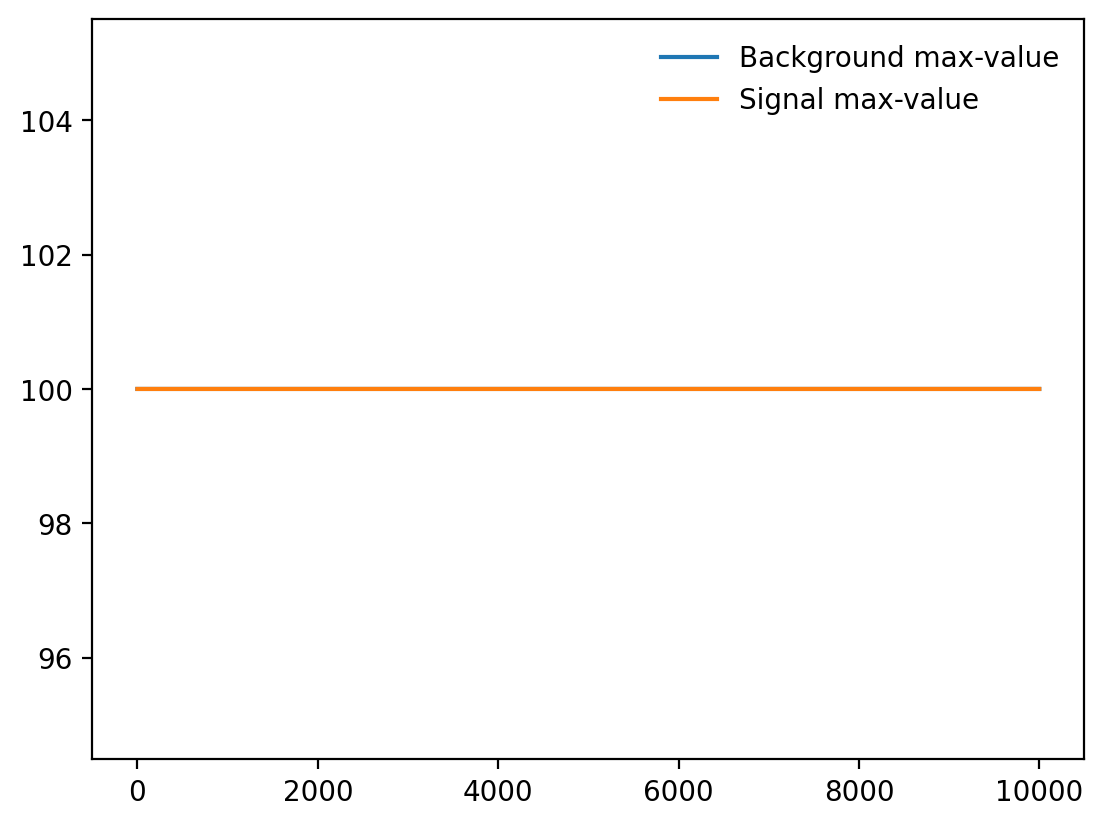

In [105]:
plt.figure()
maxcheck = []
for i in range(len(X_BG)):
    maxcheck.append(np.max(X_BG[i]))
    
plt.plot(maxcheck,'-', label='Background max-value')

maxcheck = []
for i in range(len(X_S)):
    maxcheck.append(np.max(X_S[i]))
    
plt.plot(maxcheck,'-', label='Signal max-value')

plt.legend()

> Here, we can see that all the images have the same np.max value of 100. The images have been processed successfully.

Creating the testing and training data. Here, 60% of the data went into the training dataset, and the rest was used for testing.

In [106]:
#randomly shuffle data:
np.random.shuffle(X_BG)
np.random.shuffle(X_S)

#Label data:
y_S = np.zeros(len(X_S)) 
y_BG = np.ones(len(X_BG)) 

#Stack signal and background data (both label and otherwise) on top of each other:
X = np.append(X_S, X_BG, axis=0)
y = np.append(y_S, y_BG, axis=0)

#column representation:
y = y.reshape(len(y), 1)
print("The shape of the total label data y is:",np.shape(y))

#Add a dimensiion onto the data array for colour since CNNs are built to take colour images:
X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1))
#The input shape is: 1 image channel (the first 3 dimensions of the array) + 1 colour channel


#Split data into training and testing samples:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle = True)

#Information about the images:
print("Shape of Input Data; W + QCD (no of images X pixel X pixel X colour channel)",np.shape(X))
print("Shape of 1 Image (pixel X pixel X colour channel):", X[0].shape)
print("Number of input samples:", len(X))

print()
print("Shape of Input Data (no of images X pixel X pixel X colour channel):", np.shape(X))

print()
print("Number of training images:", len(X_train))
print("Number of test images:", len(X_test))

The shape of the total label data y is: (20000, 1)
Shape of Input Data; W + QCD (no of images X pixel X pixel X colour channel) (20000, 40, 40, 1)
Shape of 1 Image (pixel X pixel X colour channel): (40, 40, 1)
Number of input samples: 20000

Shape of Input Data (no of images X pixel X pixel X colour channel): (20000, 40, 40, 1)

Number of training images: 12000
Number of test images: 8000


Now, let's plot a random image from each dataset. We will also plot the sum of all the images from each dataset to see how it looks and better understand the data we are dealing with.

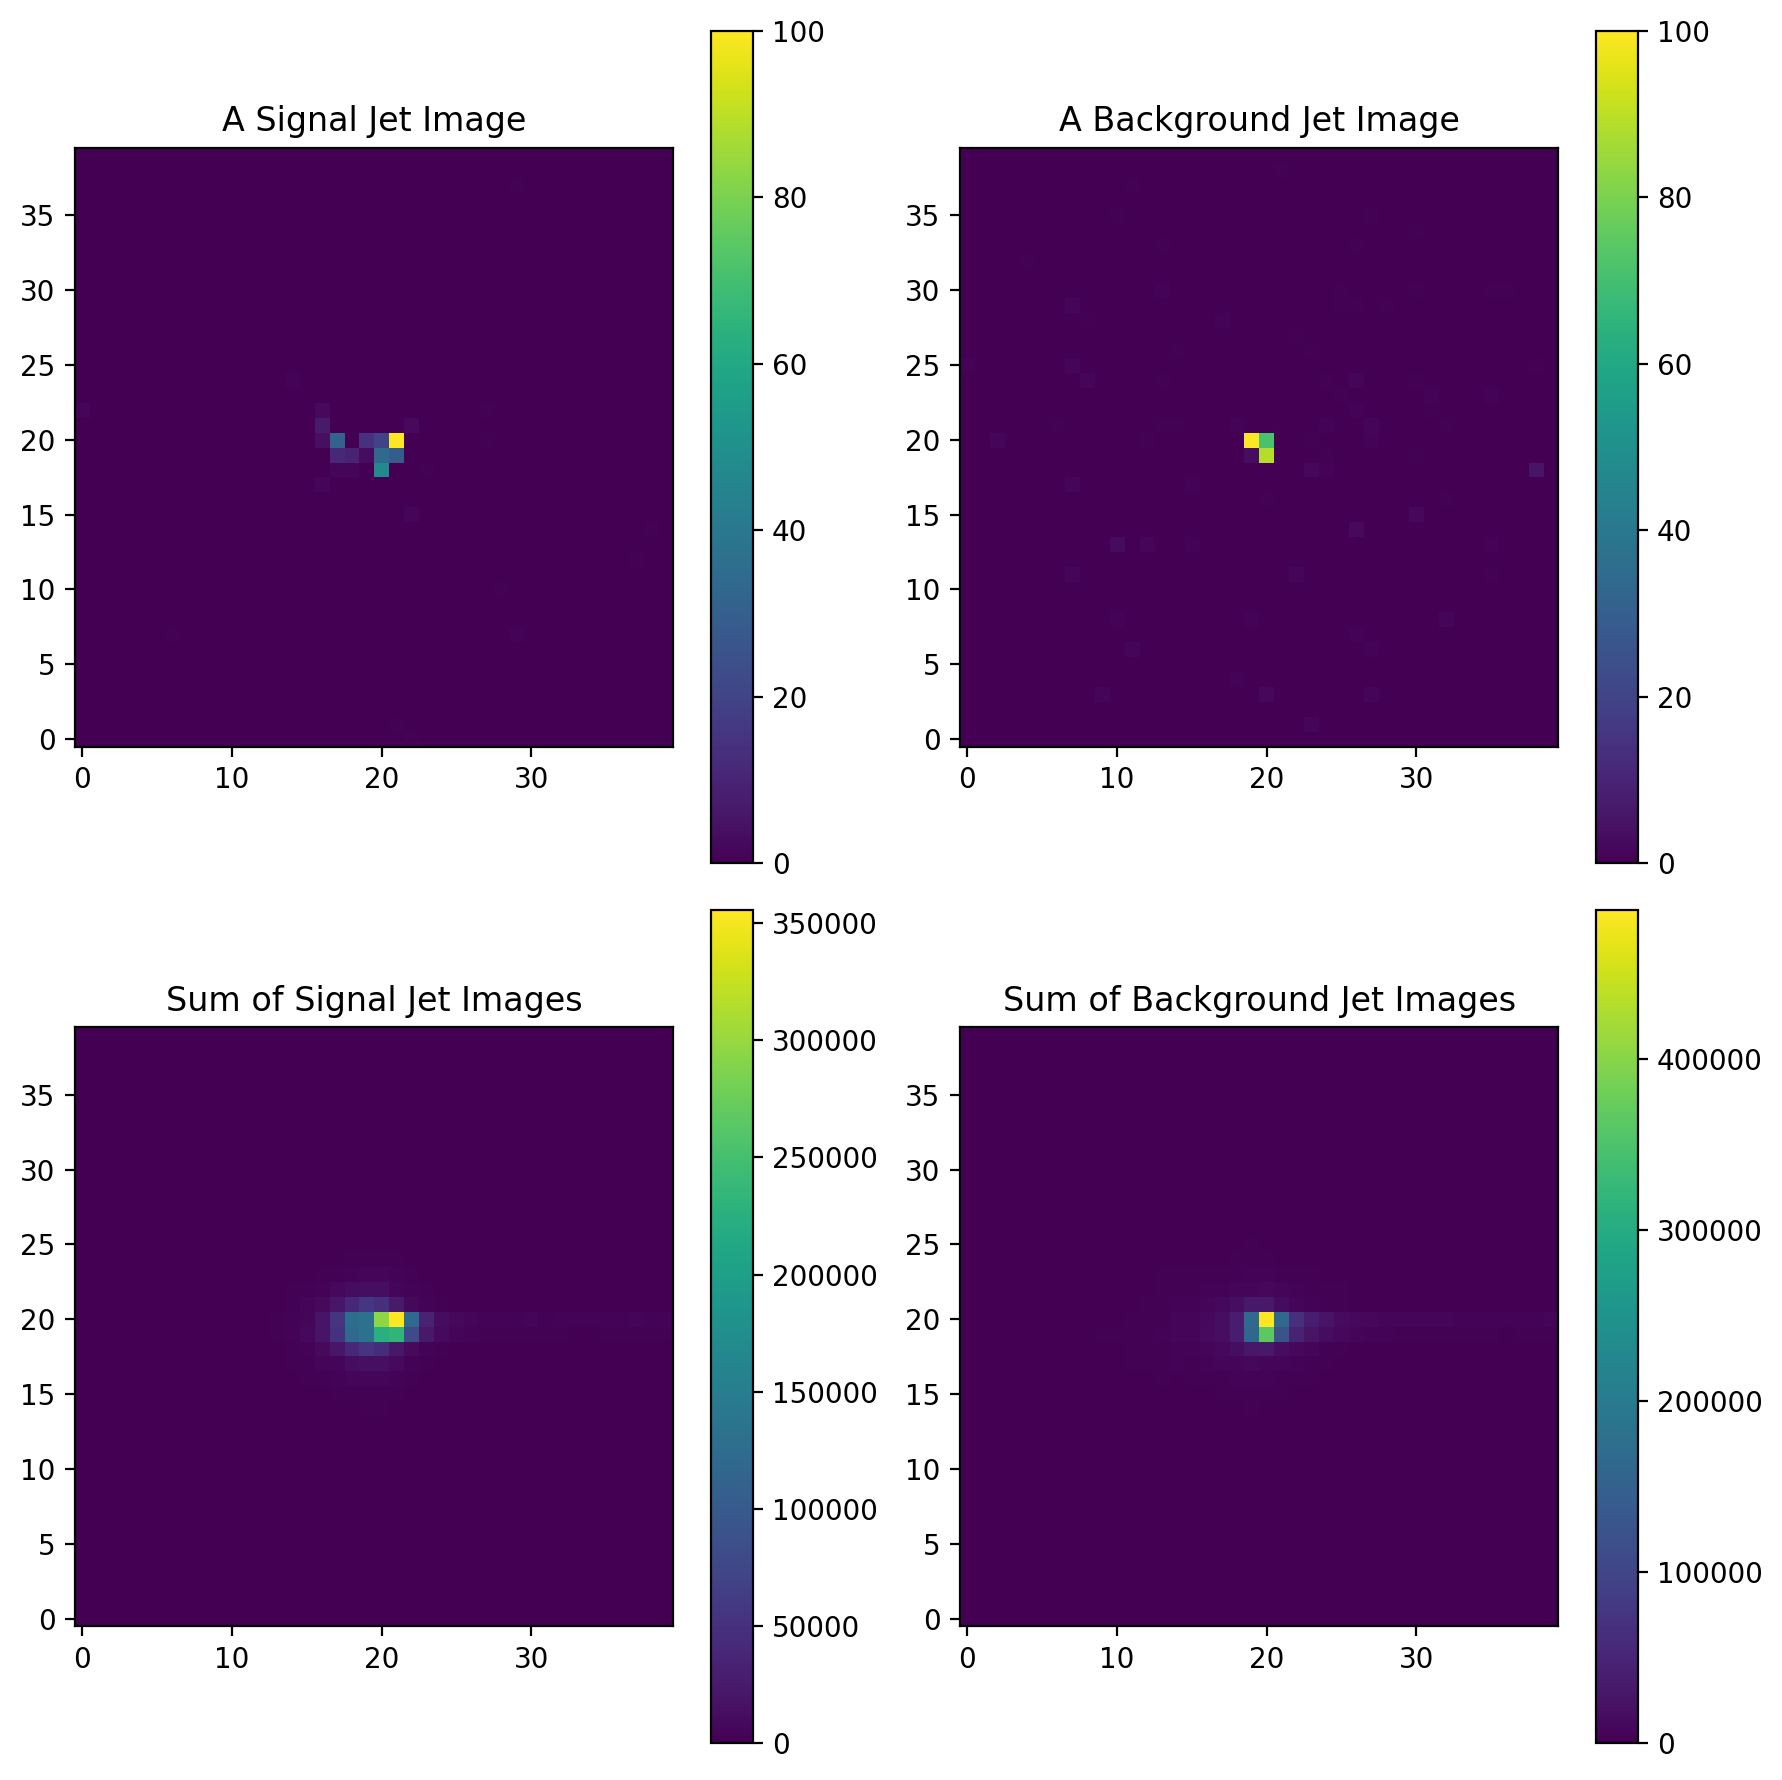

In [107]:
from astropy.visualization import (MinMaxInterval, SqrtStretch, LogStretch, ImageNormalize) #Helps generate better looking image-plots.

iimg_sig = np.random.randint(0,len(X_S))  #pick random signal image to plot
iimg_bkg = np.random.randint(0,len(X_BG)) #pick random background image to plot

fig, ax = plt.subplots(2,2, figsize=(9, 9))

ax[0][0].set_title("A Signal Jet Image")
im1 = ax[0][0].imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
fig.colorbar(im1, ax=ax[0,0])
fig.tight_layout()

ax[0][1].set_title("A Background Jet Image")
im2 = ax[0][1].imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
fig.colorbar(im2, ax=ax[0,1])
fig.tight_layout()

ax[1][0].set_title("Sum of Signal Jet Images")
im3 = ax[1][0].imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
fig.colorbar(im3, ax=ax[1,0])
fig.tight_layout()

ax[1][1].set_title("Sum of Background Jet Images")
im4 = ax[1][1].imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
fig.colorbar(im4, ax=ax[1,1])
fig.tight_layout()

> Looking at the randomly chosen Signal image, we can see that the Signal is a lot more spread out than the Background, which is very concentrated to the center. Although more apparent in other images, we can still see the appearance of two jets in the Signal image. 

> From the summed up images from the Signal and the BG, we can see that the Signal jet is a lot less localized than the Background jet. This is as expected considering that the Signal has **two** 

### The Convolutional Neural Network

#### Setting up the CNN

Here, I will be adding different types of layers to the NN and explaining each addition to the architecture.

In [127]:
Neural = keras.models.Sequential()

</br>
</br>
The convultional layer will be provided by 'Conv2D'. Here, I will be using 64 3x3 kernels, as is convention. The convultional layer is implemented to extract features from input images by applying the kernels to the images. Here, ReLU activation is used as the objective of this code is to pick out features, which is better done by ReLU.

In [128]:
Neural.add(keras.layers.Conv2D(64, (3, 3), input_shape=(40,40,1), activation='relu'))
Neural.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

</br>
</br>
Next, I will be adding a 'MaxPooling2D' layer to decrease the image size. This is done by applying a 2x2 kernel across the whole image, resulting in a smaller output. This reduction in dimensionality is implemented to:
</br>
1. Reduce computational cost of running the network.
</br>
2. Make the model more robust against variations in the input.

In [129]:
Neural.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

</br>
</br>
Next, I will be using a 'Dropout' layer as a measure against overfitting. This is accomplished by deactivating random input neurons to reduce the weights and biases in the network.  

In [130]:
Neural.add(keras.layers.Dropout(0.3))

</br>
</br>
Running another round of the layers above.

In [131]:
Neural.add(keras.layers.Conv2D(64, (3, 3), input_shape=(40,40,1), activation='relu'))
Neural.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
Neural.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
Neural.add(keras.layers.Dropout(0.3))

Now, finally, let's add a 'flatten' to convert the image into 1-dimension, following that with the addition of some regular densely-connected layers to act as a "classifier" that takes the patterns learnt by the convulutional layers and maps them to the output.
</br>
Since the end goal of this CNN is a binary classification, I have enacted the use of a sigmoid activation, as it maps any input to a value between 0 and 1. Here, the numbers 1 and 0 can correspond to each one of our two classes, with any values in between indicating the probability of an image being of one of the two classes. 

In [132]:
Neural.add(keras.layers.Flatten())
Neural.add(keras.layers.Dense(50, activation='relu'))
Neural.add(keras.layers.Dense(1, activation='sigmoid'))

Let's take a look at the network summary we have here.

In [133]:
Neural.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 38, 38, 64)        640       
                                                                 
 conv2d_50 (Conv2D)          (None, 36, 36, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 18, 18, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_52 (Conv2D)          (None, 14, 14, 64)        36928     
                                                     

For the CNN, I tried to keep the number of parameters displayed at the end of the summary below 300,000. This is to minimize overfitting to training data, which makes the network better at generalizing for unseen data. This also helps in making a faster training network with reduced computing costs.

#### Training and Testing

Now, I will compile the model. As is usual, I will be using 'adam' as my optimizer. But I will be using the 'binary_crossentropy' loss function instead of 'Mean-Squared Error', as it is a better choice for binary classification problems[1]. This is partially due to Binary Cross-entropy penalizing results far from the true values more heavily, which only works to our advantage here as there are only two classes to choose from. MSE is more useful for predictions on continuous output values. 

In [134]:
Neural.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Let's finally train our network on the training data.

In [135]:
history = Neural.fit(X_train, y_train, batch_size=200, epochs=15, validation_data=(X_test,y_test))

Epoch 1/15
60/60 [==============================] - 57s 941ms/step - loss: 0.6597 - accuracy: 0.6236 - val_loss: 0.5601 - val_accuracy: 0.7325
Epoch 2/15
60/60 [==============================] - 60s 998ms/step - loss: 0.5537 - accuracy: 0.7397 - val_loss: 0.5274 - val_accuracy: 0.7458
Epoch 3/15
60/60 [==============================] - 62s 1s/step - loss: 0.5287 - accuracy: 0.7515 - val_loss: 0.5066 - val_accuracy: 0.7600
Epoch 4/15
60/60 [==============================] - 61s 1s/step - loss: 0.5197 - accuracy: 0.7565 - val_loss: 0.5023 - val_accuracy: 0.7678
Epoch 5/15
60/60 [==============================] - 60s 1s/step - loss: 0.5054 - accuracy: 0.7715 - val_loss: 0.5013 - val_accuracy: 0.7710
Epoch 6/15
60/60 [==============================] - 60s 1s/step - loss: 0.4953 - accuracy: 0.7724 - val_loss: 0.4899 - val_accuracy: 0.7719
Epoch 7/15
60/60 [==============================] - 60s 1s/step - loss: 0.4848 - accuracy: 0.7799 - val_loss: 0.4919 - val_accuracy: 0.7716
Epoch 8/15
60/

> Looking at the 'loss' and 'accuracy' values, we can see that they seem to not change as much towards the later epochs. The network seems to encounter smaller gains for the same effort. Thus, limiting the number of epochs to 15 was done to ensure that a good accuracy value (81.24%) was reached while still maintaining effeciency in the runtimes.

#### Checking the Loss and Accuracy

To evaluate our model's performance, let's take a look at our accuracy and loss values over the epochs.

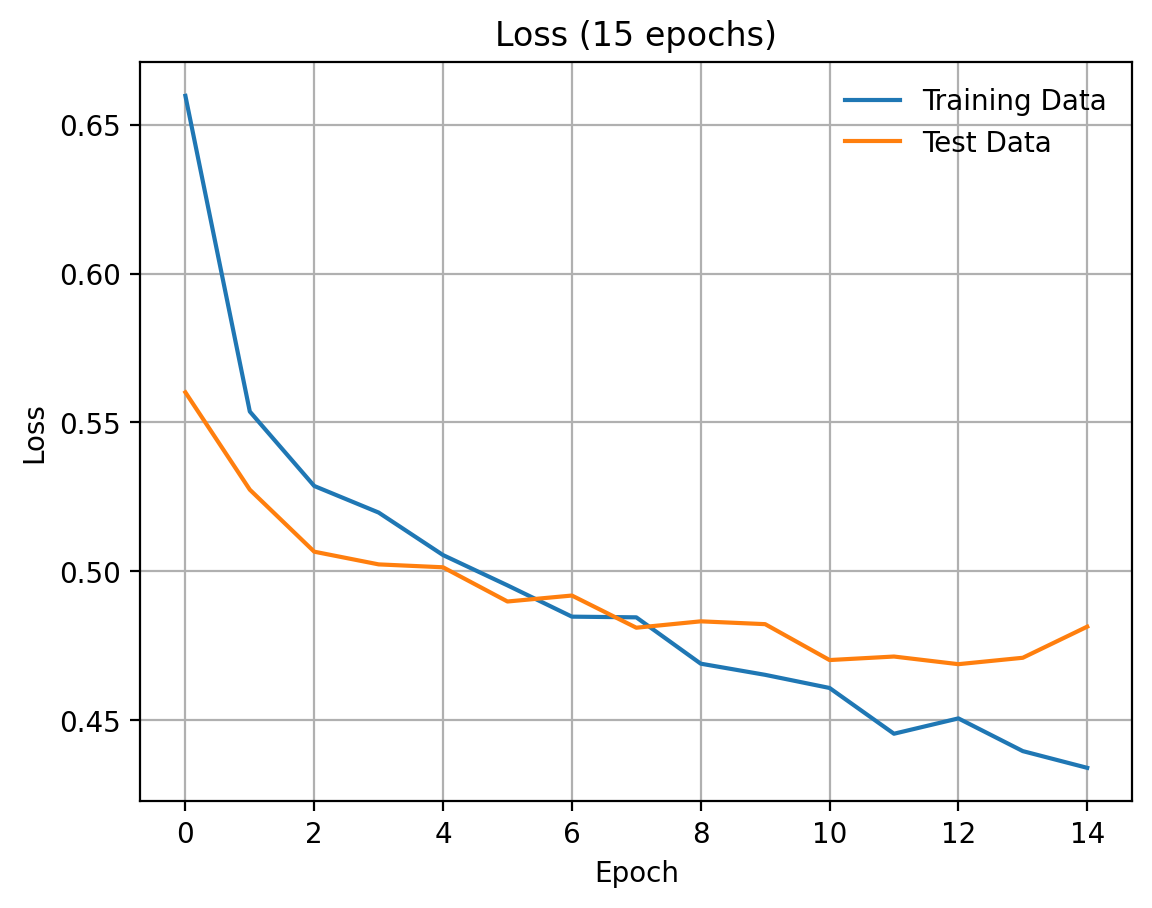

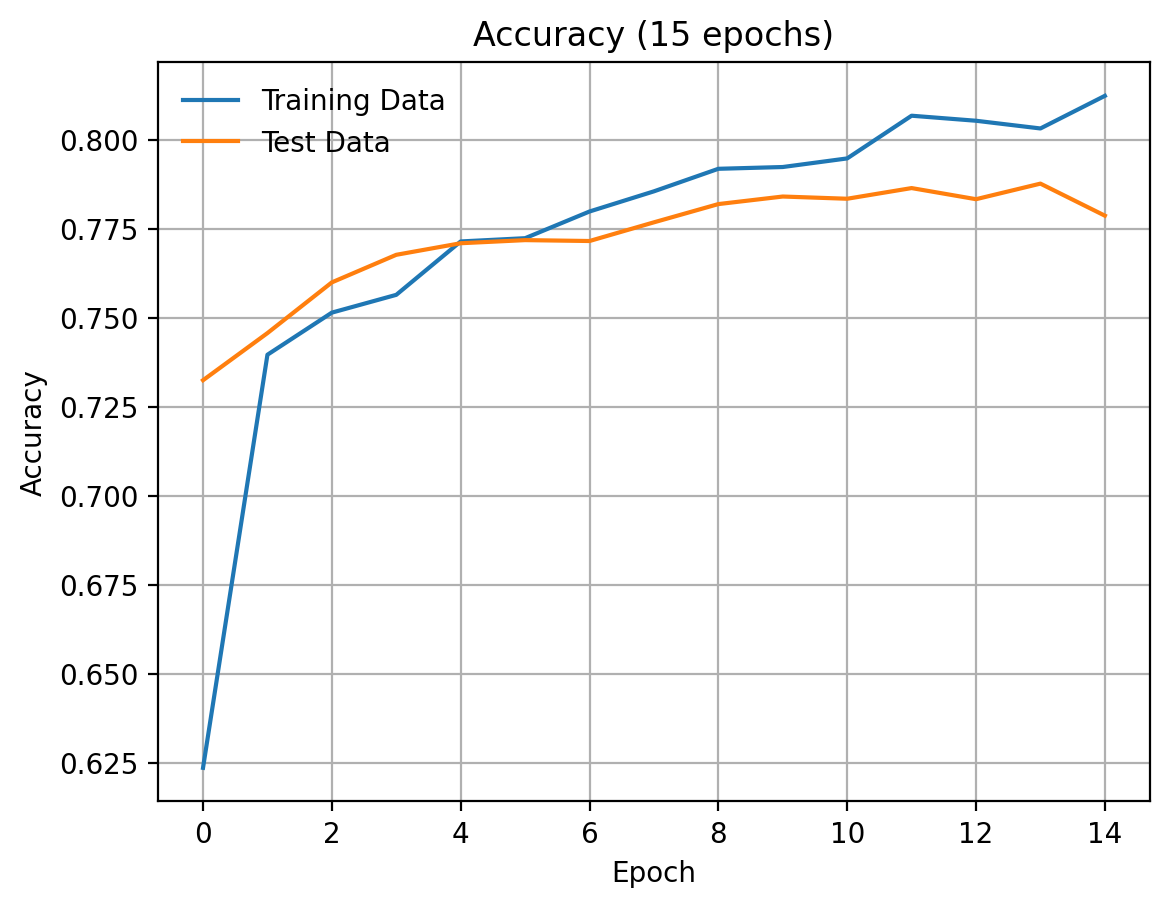

In [154]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Data") #training loss
plt.plot(history.history['val_loss'], label = "Test Data") #test loss
plt.xlabel("Epoch")
plt.grid(True, which="both")
plt.title("Loss (15 epochs)")
#plt.ylim(0,1.5)
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(history.history['accuracy'], label = "Training Data") #training loss
plt.plot(history.history['val_accuracy'], label = "Test Data") #test loss
plt.legend()
plt.grid(True, which="both")
plt.title("Accuracy (15 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

> The overfitting of loss begins at about the 6th epoch, and for the accuracy, it begins at about the 5th epoch. This is fine considering two factors: </br>
1)The difference in the training and testing values are not massive either way. The overfitting is nit very high. </br>
2)Changing the neural network (for the most part) still results in overfitting, but the point where overfitting begins changes.</br></br>
Thus, I focused on decreasing the degree of overfitting and increasing the final accuracy of the model while maintaining good code effeciency.

#### Evalutaing the CNN's ROC curve.

One of showing the effectiveness of a binary classifier system is called a ROC (Receiver Operating Characteristic) curve. For different classifying criteria, it plots the true positive rate (TPR) vs the false positive rate (FPR).</br>
The proportion of positive events (true positives) that the system correctly classifies is known as the **TP** (number of times QCD-jet was guessed correctly), whereas the proportion of negative events (false positives) that the system wrongly classifies as positive is known as the **FP** (number of times QCD-jet was guessed incorrectly). </br>
On the other end, we have true negatives (guessing W-jet correct), **TN**, and false negatives (guessing W-jet wrong), **FN**.</br>
The **TPR**, true positive rate, is the ratio of TP events and all actually positive (Background Jet) events. This can be calculated using the following equation:</br>
\
$$TPR = \frac{TP}{TP+FN}$$</br>
The **FPR**, false positive rate, is the ratio of FP events and all actually negative (Signal Jet) events. This can be calculated using the following equation:</br>
\
$$FPR = \frac{FP}{FP+TN}$$</br>
The function 'roc_curve' plots the TPR/FPR graph for varying thresholds. Here, 'threshold' means the probability at or over which the outcome will be categorised as positive </br></br>
A common way of assessing the general performance of a classifier system is the area under the ROC curve. While an area-under-curve of 0.5 implies a classifier that is no better than random, an area-under-curve of 1 shows perfect categorization.</br></br> Basically, the higher the area-under-curve, the greater the predictive power.

250/250 [==============================] - 9s 34ms/step
There are 2414 number of thresholds (i.e number of points) used to plot the ROC-curve.


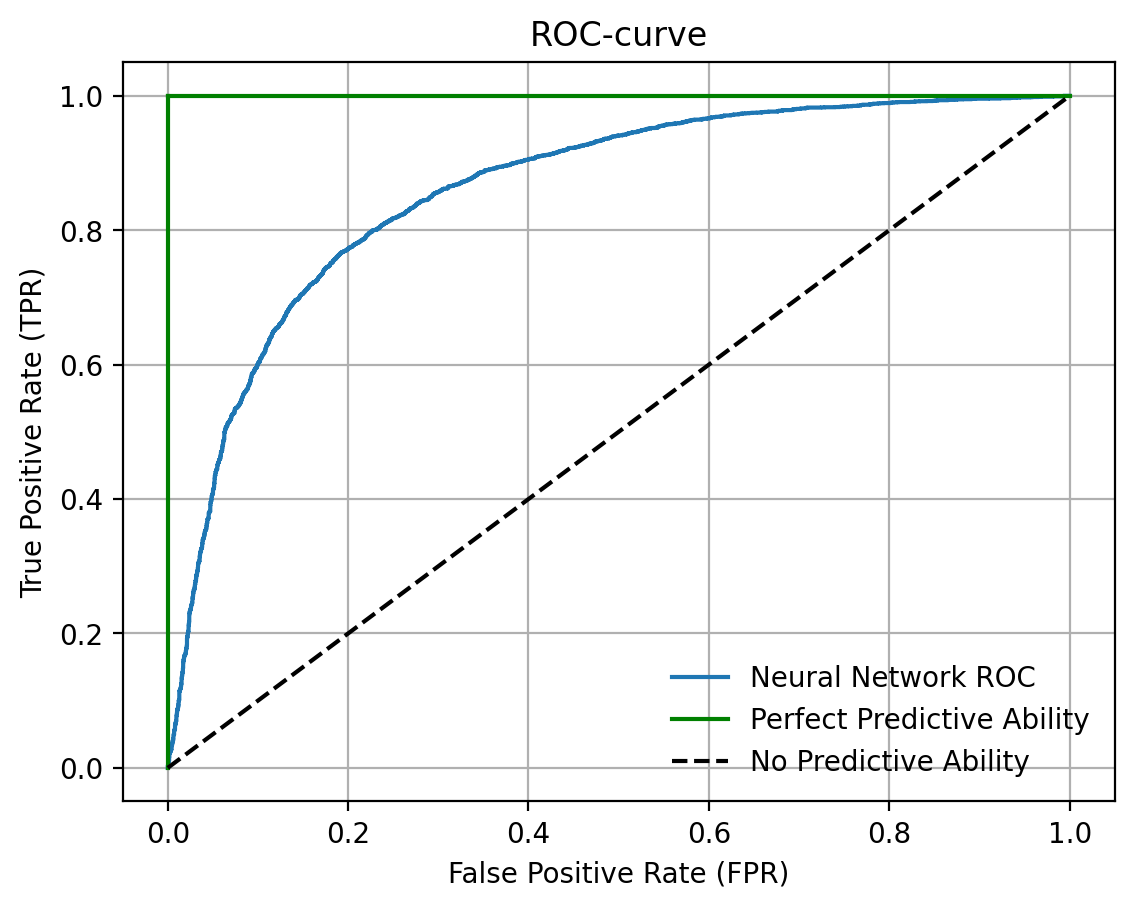

In [155]:
prediction = Neural.predict(X_test) #the test prediction required to assess performance
FPR, TPR, threshold = roc_curve(y_test, prediction) #labels and prediction is required to calculate TPR and FPR
print("There are", len(threshold), "number of thresholds (i.e number of points) used to plot the ROC-curve.")


plt.figure()
plt.plot(FPR,TPR, label='Neural Network ROC')
plt.plot([0,0],[0,1], color='green', label='Perfect Predictive Ability') #plot for perfect CNN comparison
plt.plot([0,1],[1,1], color='green')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Ability' ) #straight line for comparison
plt.legend()
plt.grid(True, which="both")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-curve")
plt.show()

Let's now use roc_auc_score to calculate the area-under-curve of our ROC-curve (Neural Network).


In [157]:
roc_auc = roc_auc_score(y_test, prediction) #requires labels and predictions
print("The area under the ROC-curve is =", roc_auc)

The area under the ROC-curve is = 0.8598356900074058


> The area-under-curve value calculated above suggests a good predictive accuracy of about 86% for our CNN. 

#### Evaluating the CNN's Precision-Recall Curve

**Precision**: The fraction of all positive predictions that are correctly guessed.
\$$Precision = \frac{TP}{TP+FP}$$</br>
**Recall**: Same as TPR.</br></br>
Similar to the ROC curve, here, the predictive ability of my CNN will judged based on the area under the curve generated by these parameters.

There are 7972 number of thresholds (i.e number of points) used to plot the PR-curve.


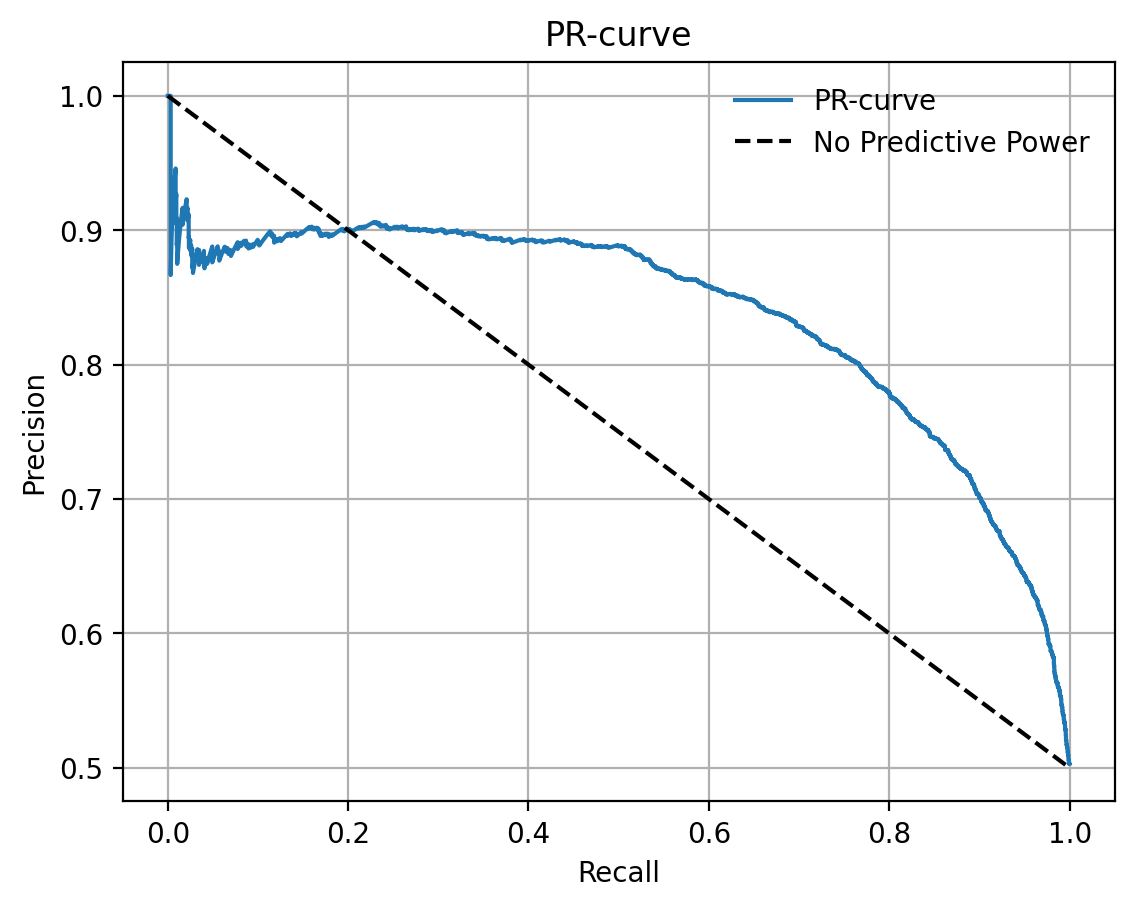

The area under the PR-curve is:  0.8375318993964844


In [158]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction) 
print("There are", len(thresholds), "number of thresholds (i.e number of points) used to plot the PR-curve.")

plt.figure()
plt.plot(recall,precision, label="PR-curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0,1],[1,0.5], '--', color='black', label='No Predictive Ability' )
plt.title("PR-curve")
plt.legend()
plt.grid(True, which="both")
plt.show()

pr_auc = auc(recall, precision) #calculating the area under the curve
print("The area under the PR-curve is: ",pr_auc) 

We can also the precision and recall values calculated above to generate an F1-score for our neural network.</br>
This value is a harmonic mean of recall and precision. It has a range of 0 to 1, with larger numbers indicating greater performance, and 1 corresponding to a perfect score. It is calculated using the following equation:</br></br>
\$$F_1 = 2 \frac{precision × recall}{precision + recall}$$</br>
Since this calculation takes into account the network's ability to correctly identify positive events **and** avoid falsely identifying negative events, it is a great way of evaluating our CNN's performance in binary classification.


In [159]:
f1 = (2 * precision * recall) / (precision + recall)
print("The F1-score is:",f1[np.argmax(f1)])

The F1-score is: 0.7959442332065906


> Looking at the graph, the curved part is as expected, with the sharp drop in the beginning being caused by a rise in false positives, resulting in fewer correct classifications.

> Overall, our NN seems to be working very well. The F1-score and the area-under-curve of PR-curve both have high values. 

#### Evaluating the CNN's Rejection-Effeciency Curve

Here, while 'effeciency' just means the TPR value, 'rejection' actually refers to 'Background rejection'. It can be calculated using the equation:</br></br>
$$Rejection = \frac{1}{FPR} = \frac{FP + TN}{FP}$$</br>
Here, as before, we analyze the area under the curve.

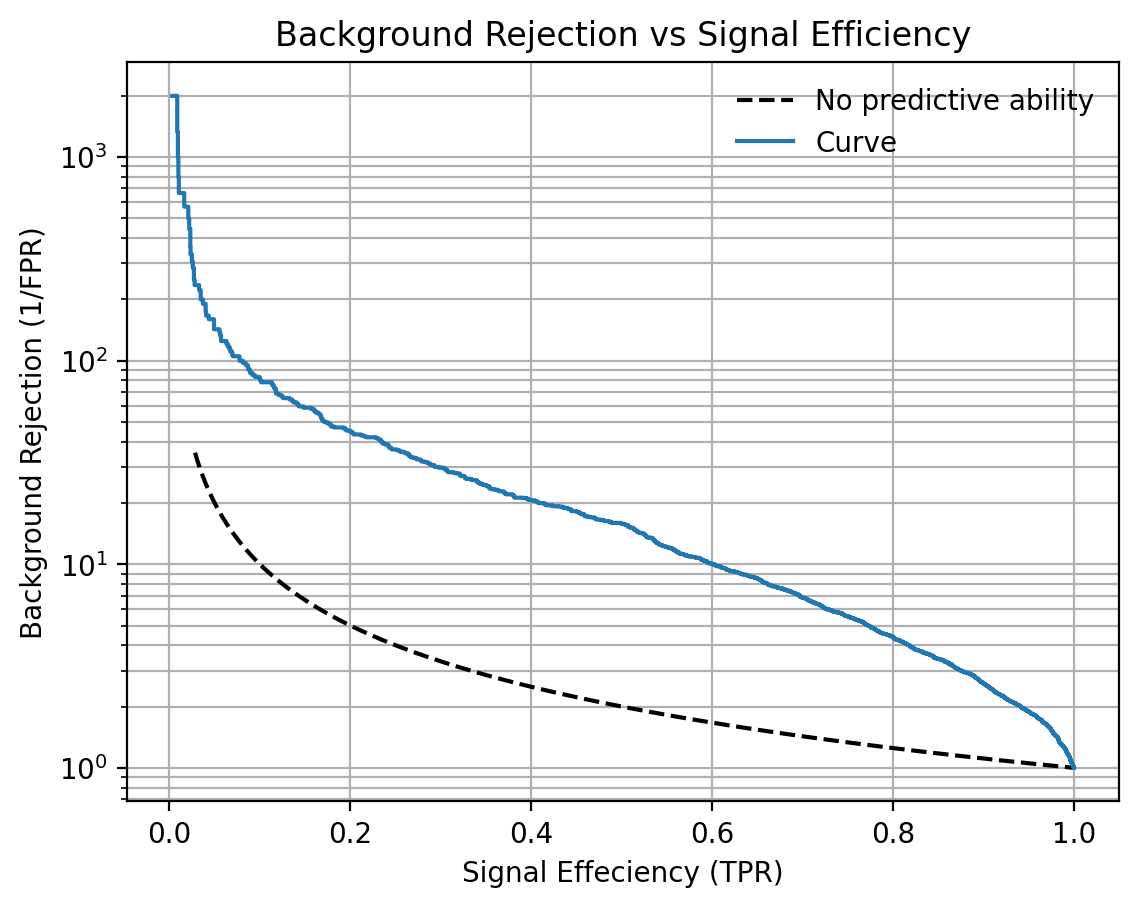

In [235]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by 0

plt.figure()
plt.plot(thresholds, 1/thresholds, '--', color="black", label="No predictive ability") #no predictive power from [2]
plt.plot(TPR,1/FPR, label="Curve")
plt.title('Background Rejection vs Signal Efficiency')
plt.xlabel("Signal Effeciency (TPR)")
plt.ylabel("Background Rejection (1/FPR)")
plt.gca().set(yscale='log') #log scale and limits
plt.grid(True, which="both")
plt.legend()
plt.show()

> Looking at the graph above, we can make the observation that the curve has a much higher area-under-curve than for the curve with no predictive ability.</br></br>
Looking further into the graph, we can find out how good the background rejection is for different effeciency-values.</br></br>
>______
>Effeciency = 50% --------> Background rejection = 15.77</br>
>Effeciency = 75% --------> Background rejection = 5.55</br>
>Effeciency = 90% --------> Background rejection = 2.58</br>
>Effeciency = 100% --------> Background rejection = 1.00</br></br>
>______
> Looking at these values and the graph above, we can see that the values seem to change the most right at the beginning, followed by small changes in the values after about SE = 0.05. This is as expected, since small increments of SE from zero would be expected to result in big drops of BG-rejection, as there is a lot of background to be removed. But as SE nears 1.0, BG-rejection also approaches unity due to FP + TN = FP holding true at this limit, resulting in FPR = 1.0

Since the Background rejection has inf-value when signal effeciency, we cannot use the conventional method to calculate the area under the curve. Instead, I enacted the use of a method that would ignore the initial FPR = 0 values and calculate the area-under-curve for the rest of the graph.

In [238]:
delta_TPR = 1/len(TPR[3:])  #Change in TPR between subsequent measurements
BG_rejection = (1 / FPR[3:])  #Array of BG-rejection values

print('The area under the curve for well-behaved section of curve is:',np.sum( (BG_rejection) * (delta_TPR) ))

The area under the curve for well-behaved section of curve is: 18.984717404455488


__________________________________
### References

[1] Baeldung. “How ReLU and Dropout Layers Work in CNNs | Baeldung on Computer Science.” Www.baeldung.com, 30 May 2020, www.baeldung.com/cs/ml-relu-dropout-layers#:~:text=As%20a%20consequence%2C%20the%20usage.